# Introduction

This case study has set its sights on neural networks.  Specifically focused on high energy physics of Higgs Bosons!  An exciting field in physics that deals with very fast, high energy collisions that quickly decay into other particles.  These exotic Higgs Bosons form and decay so quickly that they can't be directly observed, but the decayed product particles can be observed.  The process of classifying these particles is found by comparing the direction and momentum of the decayed particle.  Our task is to recreate the deep neural network used by P. Baldi et all and try to improve upon the models performance by implementing modern machine learning tools that have been developed since the release of this paper. 

# Background

The dataset created by P. Baldi et all consists of 11 million records of high energy collisions with 21 observable features and 7 manufactured features that aide physicists to classify the type of resulting particles.  After careful examination of the paper we deduced the following parameters to have been used in creation of their model.  

- Neurons = 300 per Layer
- Number of Layers = 5 Layers
- Normalization - 0 to 1
- Activation Function = tanh for the first layers, sigmoid for the last
- Learning Rate = 0.05
- Learning Rate Decay = .00001
- Momentum = 0.9
- Metrics = AUC, Accuracy
- Epoch's = 1000
- Batch Size = 100

Next because of the massive size of this dataset, we sub sample 100k rows in order to reduce computation time with training the neural network.  Initial testing on the full dataset was around 3 to 4 minutes per epoch even using Google Colab's GPU core for analysis.  By sampling 100k records, we can get that time down to 2 seconds per epoch which is far more advantageous for development.  We utilize an 80/20 train/test split and use AUC (Area under the Curve) and accuracy as our performance metrics.  

In [0]:
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras import metrics
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


# from google.colab import files
# uploaded = files.upload()
print(tf.__version__)


1 Physical GPUs, 1 Logical GPUs
2.2.0-rc1


# Background

Fill in background info on Dataset and some of the basics behind why we care about Higgs Bosons. 


# Analysis

### Baseline Model



In [0]:
#Importing dataset.  
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz'
col_names = ['Target','lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 
             'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 
             'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
full_higgs_df = pd.read_csv(url, header=None, names=col_names)

# from google.colab import files
# import io

# uploaded = files.upload()
# full_higgs_df = pd.read_csv(io.BytesIO(uploaded['HIGGS.csv']))


In [0]:
full_higgs_df.head(5)

,Target,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,-0.653674,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [0]:
#Taking the first 100k rows for faster analysis run times. 

small_higgs_df = pd.DataFrame(full_higgs_df.iloc[0:100000])
X = small_higgs_df.drop('Target', axis=1)
y = small_higgs_df.iloc[:,0]

print(X.shape)
print(y.shape)

#should probably run it through the standard scaler as well.  
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)


(100000, 28)
(100000,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases l

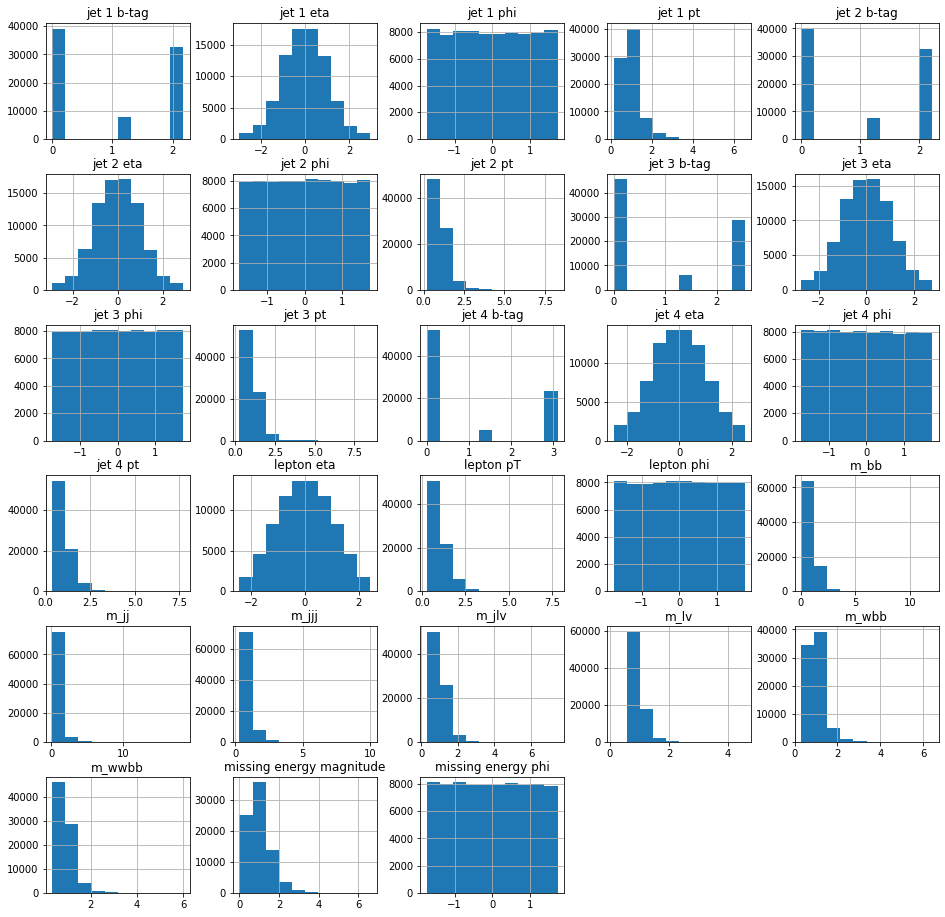

In [0]:
#Plotting some EDA over the variables before normalization. 

import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (16,16))
ax = fig.gca()
X_train.hist(ax=ax)
plt.show()


In [0]:
#Lets build that 5 layer dip!

def weird_initializer(i: int) -> tf.keras.initializers.Initializer:
  if i == 0:
    return tf.keras.initializers.RandomNormal(0,0.1)
  else: 
    return tf.keras.initializers.RandomNormal(0, 0.05)

model = tf.keras.Sequential()
hidden = [{'units': 300, 'activation': 'tanh', 'kernel_initializer': weird_initializer(i)} for i in range(5)]
for h in hidden:
  model.add(layers.Dense(**h))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.RandomNormal(0, 0.001)))


In [0]:


# use all the data!
X = full_higgs_df.drop('Target', axis=1).values.astype(np.float16)
y = np.asarray(full_higgs_df['Target']).astype(np.float16)

del full_higgs_df
import gc; gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state = 42)


In [0]:
from typing import Tuple

class generator(tf.keras.utils.Sequence):
  def __init__(self, X: np.ndarray, y: np.ndarray, batch_size: int=100, shuffle: bool=True) -> None:
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.X = X
    self.y = y
    self.on_epoch_end()
  
  def __len__(self) -> int:
    return self.X.shape[0] // self.batch_size

  def on_epoch_end(self) -> None:
    self.indexes = np.arange(self.X.shape[0])
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __getitem__(self, index: int) -> Tuple[np.ndarray, np.ndarray]:
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    return self.X[indexes, :], self.y[indexes]

X_train2, X_val, y_train2, y_val = train_test_split(X_train,y_train, test_size=0.20, random_state = 42)


train = generator(X_train2, y_train2)
val = generator(X_val, y_val)
test = generator(X_test, y_test)

In [0]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K


class LR_Moment_scheduler(Callback):
    """Callback to schedule learning rate and momentum exactly the same as in the paper
    """

    def __init__(self, eta_max: float, eta_min:float =1e-6, verbose: int=0, epoch_momentum:int=200, 
                 decay: float= 1e-5, momentum_min: float=0.9, momentum_max: float=0.99) -> None:
        super().__init__()
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.decay = decay
        self.momentum_max = momentum_max
        self.momentum_min = momentum_min
        self.moment_slope = (momentum_max - momentum_min) / epoch_momentum
  

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'learning_rate') or not hasattr(self.model.optimizer, 'momentum'):
          raise ValueError('Optimizer must have a "learning_rate"  and "momentum" attribute.')
        
        # decay learning rate, with a minumum
        lr = self.eta_max * 1/(1+ self.decay*epoch)
        if lr < self.eta_min:
          lr = self.eta_min
        K.set_value(self.model.optimizer.learning_rate, lr)
        
        # increase momentum, with a maximum
        momentum = self.momentum_min + epoch*self.moment_slope
        if momentum > self.momentum_max:
          momentum = self.momentum_max
        K.set_value(self.model.optimizer.momentum, momentum)

        if self.verbose > 0:
          print('\nEpoch %05d: scheduler setting learning '
                  'rate to %s., momentum to %s' % (epoch + 1, lr, momentum))


    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['learning_rate'] = K.get_value(self.model.optimizer.learning_rate)
        logs['momentum'] = K.get_value(self.model.optimizer.momentum)



In [0]:
optimiz = tf.keras.optimizers.SGD(learning_rate=0.05,
                                  momentum=0.95, nesterov=True)
schedule = LR_Moment_scheduler(0.05, verbose=1)


check = tf.keras.callbacks.ModelCheckpoint(
    "recreate.h5", monitor="val_loss", save_best_only=True
)

# first we go with no stopping for 200 epochs
stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10)
model.compile(optimizer=optimiz,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(train, validation_data = val, epochs=200, steps_per_epoch = len(train)//20,
          validation_steps = len(val) // 5 , callbacks = [schedule, stopper, check])


Epoch 00001: scheduler setting learning rate to 0.05., momentum to 0.9
Epoch 1/200
3520/3520 [==============================] - 19s 5ms/step - loss: 0.5870 - accuracy: 0.6855 - val_loss: 0.5765 - val_accuracy: 0.6923 - learning_rate: 0.0500 - momentum: 0.9000

Epoch 00002: scheduler setting learning rate to 0.04999950000499995., momentum to 0.90045
Epoch 2/200
3520/3520 [==============================] - 19s 5ms/step - loss: 0.5692 - accuracy: 0.7006 - val_loss: 0.5588 - val_accuracy: 0.7093 - learning_rate: 0.0500 - momentum: 0.9004

Epoch 00003: scheduler setting learning rate to 0.04999900001999961., momentum to 0.9009
Epoch 3/200
3520/3520 [==============================] - 19s 5ms/step - loss: 0.5591 - accuracy: 0.7091 - val_loss: 0.5604 - val_accuracy: 0.7095 - learning_rate: 0.0500 - momentum: 0.9009

Epoch 00004: scheduler setting learning rate to 0.04999850004499865., momentum to 0.90135
Epoch 4/200
3520/3520 [==============================] - 19s 5ms/step - loss: 0.5486 - ac

In [0]:
print("finished training! Note the fact we dont need to train 1000 epochs")

finished training! Note the fact we dont need to train 1000 epochs


In [0]:
from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, model.predict(X_test)))

AUC: 0.835902971532381


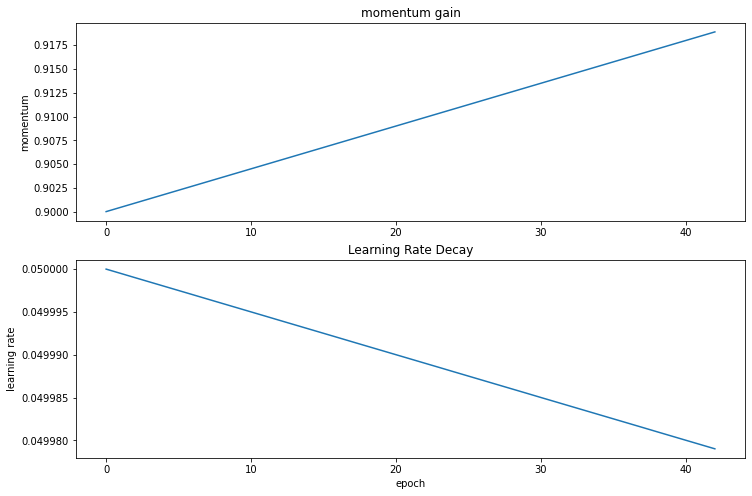

In [0]:
plt.subplot(212)
plt.plot(history.history['learning_rate'])
plt.title('Learning Rate Decay')
plt.ylabel('learning rate')
plt.xlabel('epoch')
# summarize history for loss
plt.subplot(211)
plt.plot(history.history['momentum'])
plt.title('momentum gain')
plt.ylabel('momentum')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()

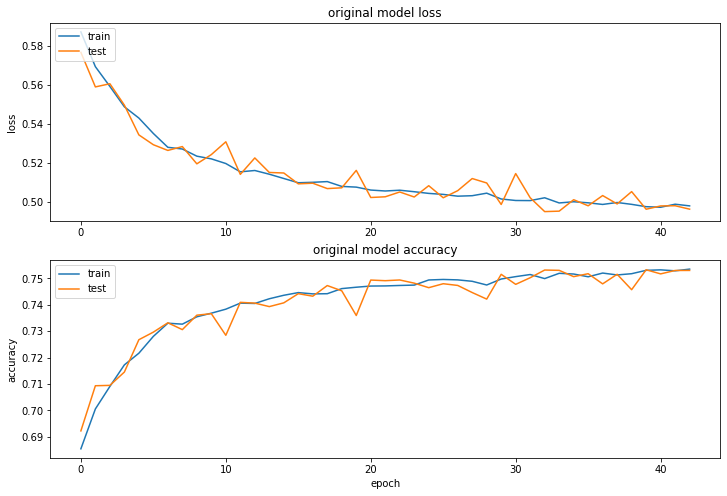

In [0]:
plt.subplot(212)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('original model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(211)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('original model loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()

In [0]:
# Now lets improve using modern activations and optimization!
import tensorflow_addons as tfa
import math
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Layer

class Mish(Layer):
    '''
    Mish Activation Function.
    .. math::
        mish(x) = x * tanh(softplus(x)) = x * tanh(ln(1 + e^{x}))
    Shape:
        - Input: Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
        - Output: Same shape as the input.
    Examples:
        >>> X_input = Input(input_shape)
        >>> X = Mish()(X_input)
    '''

    def __init__(self, **kwargs):
        super(Mish, self).__init__(**kwargs)
        self.supports_masking = True

    def call(self, inputs):
        return inputs * K.tanh(K.softplus(inputs))

    def get_config(self):
        base_config = super(Mish, self).get_config()
        return dict(list(base_config.items()))

    def compute_output_shape(self, input_shape):
            return input_shape



model2 = tf.keras.Sequential()
# networks should be expanding, this avoids dead neurons (find citation)
units = [100, 147, 200, 250, 300]
hidden = [{'units': units[i], 'activation': Mish()} for i in range(5)]
for h in hidden:
  model2.add(layers.Dense(**h))
#model.add(layers.Dropout(0.5))
model2.add(layers.Dense(1, activation = 'sigmoid'))


def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    """
        function returning a tf.keras.optimizers.Optimizer object
        returned optimizer is a Ranger optimizer
        Ranger is an optimizer combining RAdam (https://arxiv.org/abs/1908.03265) and Lookahead (https://arxiv.org/abs/1907.0861)
        returned optimizer can be fed into the model.compile method of a tf.keras model as an optimizer
        ...
        Attributes
        ----------
        learning_rate : float
            step size to take for RAdam optimizer (depending on gradient)
        beta_1 : float
            parameter that specifies the exponentially moving average length for momentum (0<=beta_1<=1)
        beta_2 : float
            parameter that specifies the exponentially moving average length for variance (0<=beta_2<=1)
        epsilon : float
            small number to cause stability for variance division
        weight_decay : float
            number with which the weights of the model are multiplied each iteration (0<=weight_decay<=1)
        amsgrad : bool
            parameter that specifies whether to use amsgrad version of Adam (https://arxiv.org/abs/1904.03590)
        total_steps : int
            total number of training steps
        warmup_proportion : float
            the proportion of updated over which the learning rate is increased from min learning rate to learning rate (0<=warmup_proportion<=1)
        min_lr : float
            learning rate at which the optimizer starts
        k : int
            parameter that specifies after how many steps the lookahead step backwards should be applied
        alpha : float
            parameter that specifies how much in the direction of the fast weights should be moved (0<=alpha<=1)
    """
    # create RAdam optimizer
    inner = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    # feed RAdam optimizer into lookahead operation
    optim = tfa.optimizers.Lookahead(inner, sync_period, slow_step_size, name)
    return optim

optim = Ranger(learning_rate = 1e-3)
model2.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [0]:
from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler.
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0, epoch_start=80, restart_epochs=None, gamma=1, expansion=1, flat_end = False):
        super(CosineAnnealingScheduler, self).__init__()
        self.epoch_start=epoch_start
        self.expansion=expansion
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose
        self.restart_epochs = restart_epochs
        self.gamma = gamma
        self.flat_end = flat_end

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'learning_rate'):
            raise ValueError('Optimizer must have a "learning_rate" attribute.')
        if epoch > self.epoch_start - 1:
            if self.restart_epochs is None:
                learning_rate = self.eta_min + (self.eta_max*self.gamma - self.eta_min) * (1 + math.cos(math.pi * (epoch - self.epoch_start) / self.T_max)) / 2
                K.set_value(self.model.optimizer.learning_rate, learning_rate)
            else:
                learning_rate = self.eta_min + (self.eta_max*self.gamma - self.eta_min) * (1 + math.cos(math.pi * ((epoch  % (self.restart_epochs+self.epoch_start)) - self.epoch_start) / self.T_max)) / 2
                K.set_value(self.model.optimizer.learning_rate, learning_rate)
            if learning_rate<=self.eta_min:
                self.eta_max *= self.gamma
                self.T_max *=self.expansion
        if self.flat_end and epoch >= ((self.epoch_start -1 ) + T_max):
            learning_rate = self.eta_min

        else:
            learning_rate=self.model.optimizer.learning_rate
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, learning_rate))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['learning_rate'] = K.get_value(self.model.optimizer.learning_rate)



In [0]:
schedule = CosineAnnealingScheduler(T_max=50, eta_max=1e-3, eta_min=1e-5, verbose=1, epoch_start=5)
history2 = model2.fit(train, validation_data = val, epochs=55, steps_per_epoch = len(train)//20,
          validation_steps = len(val) // 5 , callbacks = [schedule])




Epoch 00001: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 1/55
3520/3520 [==============================] - 45s 13ms/step - loss: 0.6289 - accuracy: 0.6399 - val_loss: 0.5963 - val_accuracy: 0.6774 - learning_rate: 0.0010

Epoch 00002: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 2/55
3520/3520 [==============================] - 45s 13ms/step - loss: 0.5891 - accuracy: 0.6824 - val_loss: 0.5826 - val_accuracy: 0.6896 - learning_rate: 0.0010

Epoch 00003: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>.
Epoch 3/55
3520/3520 [==============================] - 46s 13ms/step - loss: 0.5717 - accuracy: 0.6984 - val_loss: 0.5603 - val_accuracy: 0.7064 - learning_rate: 0.0010

Epoch 00004: CosineAnnealingScheduler setting learning rate to <tf.Variable 'learning_rate

In [0]:
print("AUC:", roc_auc_score(y_test,  model2.predict(X_test)))

AUC: 0.856588915374834


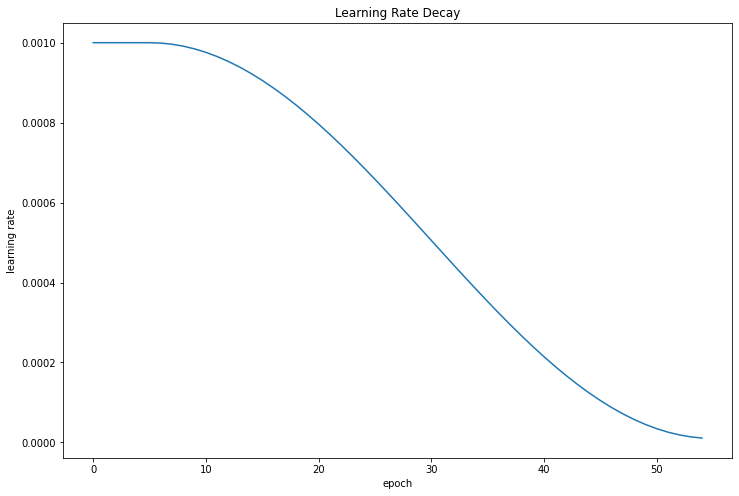

In [0]:

plt.plot(history2.history['learning_rate'])
plt.title('Learning Rate Decay')
plt.ylabel('learning rate')
plt.xlabel('epoch')
# summarize history for loss
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()

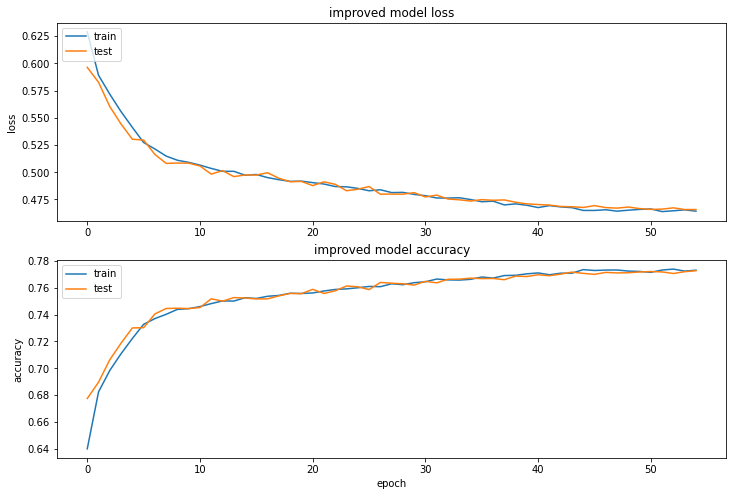

In [0]:
plt.subplot(212)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('improved model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(211)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('improved model loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2)
plt.show()